In [1]:
from IPython import get_ipython
# !pip install cvxopt
# !pip install quandl
# !pip install watson_developer_cloud
# !pip install iexfinance
# !pip install fuzzywuzzy
# !pip install python-Levenshtein
# !pip install seaborn
# !pip install urllib3
# !pip install ttr
# !pip install ipython

In [2]:
import watson_developer_cloud
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from iexfinance.stocks import get_historical_data 
# from datetime import datetime
# %matplotlib inline
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
np.random.seed(123)
solvers.options['show_progress'] = False
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
from cvxopt import matrix
from numpy import array
from scipy import stats
import scipy
import requests
import quandl
import datetime
import pandas_datareader.data as web
from difflib import get_close_matches 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from matplotlib import cm

C:\Users\Naga Raja Paidimarri\Anaconda3\envs\py35\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## collecting and maintaining a universe of assets

In [3]:
dftickerstocksETF = pd.read_csv("dftickerstocksandETF")
dftickerstocksETF =dftickerstocksETF.drop('Unnamed: 0',axis = 1)

In [4]:
dftickerstocksETF['Sector'] = dftickerstocksETF['Sector'].fillna('Other')

In [5]:
dftickerstocksETF = dftickerstocksETF[['Symbol','Security Name','Sector','industry','MarketCap']]

In [6]:
# # greater than 10, Morningstar Performance Rating Overall
# topETFlistyahoo = pd.read_excel('topetflistyahoo.xlsx')

In [7]:
# # Most Actives - US, Mid Cap and Large Cap and Mega Cap, Volume (Intraday):greater than 5000000
# topstockslistyahoo = pd.read_excel('topstockslistyahoo.xlsx')

#### This function would take a dataframe of historical asset prices and expected return to returns weights after solving MVO problem

In [8]:
def meanvariance(final,expected_return,blreturns = []):
    
#     start = datetime.datetime(2017, 1, 1) 
#     end = datetime.datetime(2019, 1, 1)
    returns = final.pct_change()
    returns = returns.iloc[1:]
    mean_returns = returns.mean()*250
    cov_matrix = returns.cov()*250
    n = len(mean_returns)

    # Create constraint matrices
    G1 = -matrix(np.eye(n))  
    G2 = matrix(-mean_returns).trans()
    G = matrix(np.concatenate((G2, G1), axis=0))
    #G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h1 = matrix(0.0, (n ,1))
    h2 = matrix(expected_return/100, (1 ,1))
    h = matrix(np.concatenate((h2, h1), axis=0))
    #h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)  
    p = matrix(0.0,(n,1))  
    cov_matrix = matrix(cov_matrix.values)
    
    weights = solvers.qp(2*cov_matrix,p, G, h, A, b)
    weights = array(weights['x']).tolist()   
    weights = [x[0] for x in weights]    
    return weights

In [131]:
def efficientfrontierabsolute(final,points = 20,riskfreerate = 0.0167,blreturns = []):
    
    returns = final.pct_change()
    returns = returns.iloc[1:]
    mean_returns = returns.mean()*250
    cov_matrix = returns.cov()*250
    n = len(mean_returns)
#     print(mean_returns)
    
    if len(blreturns) != 0:
#         blreturns = [x[0] for x in blreturns]
#         blreturns = array(blreturns)
        mean_returns = pd.Series(blreturns, index =mean_returns.index )
#     print('after')
#     print(mean_returns)
    
    rangeofreturns = np.linspace(0,mean_returns.max(),points)
    weights = pd.DataFrame(columns = final.columns)
    
    G1 = -matrix(np.eye(n))  
    G2 = matrix(-mean_returns).trans()
    G = matrix(np.concatenate((G2, G1), axis=0))
    #G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h1 = matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)  
    p = matrix(0.0,(n,1))  
    cov_matrix = matrix(cov_matrix.values)
    
    for i in rangeofreturns:
#         print(i)
        # Create constraint matrices        
        h2 = matrix(-i, (1 ,1))
        h = matrix(np.concatenate((h2, h1), axis=0))
        #h = opt.matrix(0.0, (n ,1))        
        weight = solvers.qp(2*cov_matrix,p, G, h, A, b)
#         print(weight['x'])
        weight = array(weight['x']).tolist()   
        weight = [x[0] for x in weight] 
        weights = weights.append(pd.Series(weight,index = final.columns),ignore_index=True)
            
    # risk and return
    returns = [blas.dot(matrix(mean_returns).trans(), matrix(x[1])) for x in weights.iterrows()]
    risks = [np.sqrt(array(matrix(x[1]).trans()*cov_matrix*matrix(x[1]))[0][0]) for x in weights.iterrows()]
        
    All = weights.copy()
    All['risk'] = risks
    All['returns'] = returns
    All['Sharpe Ratio'] = (All['returns'] - riskfreerate)/ All['risk'] 
    
    return weights, All

In [132]:
def maxsharpe(final,expected_return = 0.10,riskfreerate = 0.0167,blreturns = []):
    
#     start = datetime.datetime(2017, 1, 1) 
#     end = datetime.datetime(2019, 1, 1)
        
    returns = final.pct_change()
    returns = returns.iloc[1:]
    mean_returns = returns.mean()*250
    cov_matrix = returns.cov()*250
    n = len(mean_returns)
    
    weight = pd.DataFrame(columns = final.columns)

    rf = 0.025

    Q1 = matrix(cov_matrix.values)
    Q2 = matrix(np.zeros(n)).trans()
    Q3 = matrix(np.zeros(n+1))
    Q4 = matrix(np.concatenate((Q1,Q2),axis = 0))
    cov_matrix = matrix(np.concatenate((Q4,Q3),axis = 1))
         
    h1 = mean_returns.values - rf
    h2 = np.zeros(1)
    h3 = matrix(np.concatenate((h1,h2),axis=0)).trans()

    h4 = np.ones(n)
    h5 = -np.ones(1)
    h6 = matrix(np.concatenate((h4,h5),axis=0)).trans()

    A = matrix(np.concatenate((h3,h6),axis=0))
    b = opt.matrix([1.0, 0.0], (2,1))
    p = matrix(0.0,(n+1,1)) 
    
    G = -matrix(np.eye(n+1))  
    h = matrix(np.zeros(n+1))
    
    #weights = solvers.qp(2*cov_matrix,p, G, h, A, b)
    weights = solvers.qp(2*cov_matrix,p, G, h, A, b)
    weights = array(weights['x']).tolist()
    weights = [x[0]/weights[-1][0] for x in weights][0:-1]
    
    weight = weight.append(pd.Series(weights,index = final.columns),ignore_index=True)
    cov_matrix = returns.cov()*np.sqrt(250)
        # risk and return
    returns = [blas.dot(matrix(mean_returns).trans(), matrix(weights))]
    risks = [np.sqrt(array(matrix(weights).trans()*matrix(cov_matrix.values)*matrix(weights))[0][0])]

    All = weight.copy()
    All['risk'] = risks
    All['returns'] = returns
    All['Sharpe Ratio'] = (All['returns'] - riskfreerate)/ All['risk'] 
        
    
    return weights, All

In [133]:
# final = getdatastocks(['aapl','msft','ms'])

In [134]:
def meanvariancetrackingindex(index,final,blreturns = []):
       
    final = pd.concat([final, index], axis=1)
    
    returns = final.pct_change()
    returns = returns.iloc[1:]
    mean_returns = returns.mean()*250
    cov_matrix = returns.cov()*250    
    expected_return = mean_returns[-1]
    mean_returns = mean_returns[:-1]
    

    beta = cov_matrix.iloc[-1,:][:-1]/cov_matrix.iloc[-1,:][-1]
    cov_index = cov_matrix.iloc[-1,-1]
    cov_matrix = cov_matrix.iloc[:-1,:-1]

    n = len(mean_returns)

    # Create constraint matrices
    G1 = -matrix(np.eye(n))  
    G2 = matrix(-mean_returns).trans()
    G = matrix(np.concatenate((G2, G1), axis=0))
    #G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h1 = matrix(0.0, (n ,1))
    h2 = matrix(expected_return/100, (1 ,1))
    h = matrix(np.concatenate((h2, h1), axis=0))
    #h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)  
    p = matrix(beta*cov_index)  
    cov_matrix = matrix(cov_matrix.values)
    
    weights = solvers.qp(2*cov_matrix,p, G, h, A, b)
    weights = array(weights['x']).tolist()  
    weights = [x[0] for x in weights] 
    return weights   

In [135]:
def efficientfrontierrelative(final,index,points = 20,riskfreerate = 0.0167, blreturns = []):
       
    finaltemp = pd.concat([final, index], axis=1)
    
    returns = finaltemp.pct_change()
    returns = returns.iloc[1:]
    mean_returns = returns.mean()*250
    
    
    cov_matrix = returns.cov()*250    
    expected_return = mean_returns[-1]
    mean_returns = mean_returns[:-1]
    

    beta = cov_matrix.iloc[-1,:][:-1]/cov_matrix.iloc[-1,:][-1]
    cov_index = cov_matrix.iloc[-1,-1]
    cov_matrix = cov_matrix.iloc[:-1,:-1]

    n = len(mean_returns)

    rangeofreturns = np.linspace(0,mean_returns.max(),points)
    weights = pd.DataFrame(columns = final.columns)
    
    
    G1 = -matrix(np.eye(n))  
    G2 = matrix(-mean_returns).trans()
    G = matrix(np.concatenate((G2, G1), axis=0))
    #G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h1 = matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)  
    p = matrix(beta*cov_index)   
    cov_matrix = matrix(cov_matrix.values)
    
    for i in rangeofreturns:
#         print(i)
        # Create constraint matrices        
        h2 = matrix(-i, (1 ,1))
        h = matrix(np.concatenate((h2, h1), axis=0))
        #h = opt.matrix(0.0, (n ,1))        
        weight = solvers.qp(2*cov_matrix,p, G, h, A, b)
#         print(weight['x'])
        weight = array(weight['x']).tolist()   
        weight = [x[0] for x in weight] 
        weights = weights.append(pd.Series(weight,index = final.columns),ignore_index=True)
    
        # risk and return
    returns = [blas.dot(matrix(mean_returns).trans(), matrix(x[1])) for x in weights.iterrows()]
    risks = [np.sqrt(array(matrix(x[1]).trans()*cov_matrix*matrix(x[1]))[0][0]) for x in weights.iterrows()]
    trackingerror = [np.sqrt(array(matrix(x[1]).trans()*cov_matrix*matrix(x[1]))[0][0] - matrix(beta*cov_index).trans()*matrix(x[1]))[0][0] for x in weights.iterrows()]
        
    All = weights.copy()
    All['risk'] = risks
    All['returns'] = returns
    All['Tracking Error'] = trackingerror
    All['Sharpe Ratio'] = (All['returns'] - riskfreerate)/ All['risk'] 
    
    return weights, All

#### This function would take a dataframe of historical asset prices and simply returns equally weighted portfolio

In [136]:
def equallyweighted(final,expected_return= 0.10,riskfreerate = 0.0167,blreturns = []):
    
    returns = final.pct_change()
    returns = returns.iloc[1:]
    mean_returns = returns.mean()*250
    cov_matrix = returns.cov()*250
    n = len(mean_returns)
    
        
#     start = datetime.datetime(2017, 1, 1) 
#     end = datetime.datetime(2019, 1, 1)
    weight = pd.DataFrame(columns = final.columns)
        
    numberofassets = final.shape[1]
    weights = np.ones((1,numberofassets), dtype = float)
    weights = weights*(1/numberofassets)
    weights = weights.tolist()[0]
    
    weight = weight.append(pd.Series(weights,index = final.columns),ignore_index=True)

        # risk and return
    returns = [blas.dot(matrix(mean_returns).trans(), matrix(weights))]
    risks = [np.sqrt(array(matrix(weights).trans()*matrix(cov_matrix.values)*matrix(weights))[0][0])]

    All = weight.copy()
    All['risk'] = risks
    All['returns'] = returns
    All['Sharpe Ratio'] = (All['returns'] - riskfreerate)/ All['risk']   
    return weights, All

In [137]:
# equallyweighted(final)

In [138]:
# def robustoptimization(final):
    

#### This function would take a dataframe of historical asset prices and assume this as historical scenarios. From these scenarios it would determine the weights which minimizes the tail risk CVAR

In [17]:
def cvaroptimization(final,expected_return):
        
    expected_return = 1
#     start = datetime.datetime(2017, 1, 1) 
#     end = datetime.datetime(2019, 1, 1)
    
    
    returns = final.pct_change()
    returns = returns.iloc[1:]
    mean_returns = returns.mean()*250
    cov_matrix = returns.cov()*250
    n = len(mean_returns)
    
    alpha = 0.95
    S = returns.shape[0]
    
    Q = matrix(np.eye(n+S+1))*0.0
    
    k = (1 / ( (1 - alpha) * S) )    
    p = matrix(np.concatenate((np.zeros(n),k * np.ones(S, dtype = float),np.ones(1, dtype = float)),axis = 0))
    
    A = matrix(np.concatenate((np.ones(n),np.zeros(S),np.zeros(1)),axis = 0)).trans()
    b = opt.matrix(1.0) 
    
    h1 = matrix(0.0, (n+S+1,1))  
    h1[n+S] = np.Inf
    h2 = matrix(-expected_return/100, (1 ,1))
    h3 = matrix(np.concatenate((matrix(np.zeros(S)),h2),axis = 0))
    h = matrix(np.concatenate((h1,h3),axis = 0))
    
    G1 = -matrix(np.eye(n+S+1)) 
    G2_1 = -matrix(returns.values)
    G2_2 = -matrix(np.eye(S))
    G2_3 = -matrix(np.ones(S))
    G2 = matrix(np.concatenate((G2_1,G2_2,G2_3),axis = 1))
    G3 = matrix(np.concatenate((array(-mean_returns),np.zeros(S+1)),axis=0)).trans()
    G = matrix(np.concatenate((G1,G2,G3),axis = 0))    

    
    #weights = solvers.qp(2*cov_matrix,p, G, h, A, b)
    weights = solvers.qp(2*Q,p, G, h, A, b)
    weights = array(weights['x']).tolist()     
    weights = [x[0] for x in weights][0:n]    
  
    return weights

In [18]:
def getdatastocks(stocks,start = datetime.datetime(2017, 1, 1),end = datetime.datetime.today()):
    final = pd.DataFrame()
    for i in stocks:
        final[i] = web.DataReader(i,data_source="yahoo",start= start,end= end)['Adj Close']
    return final   

In [19]:
def getdataindex(index,start = datetime.datetime(2017, 1, 1),end = datetime.datetime.today()):
    final = pd.DataFrame()
    index1 = '^'+index
    final[index] = web.DataReader(index1,data_source="yahoo",start= start,end= end)['Adj Close']
    return final  

In [20]:
def summarydfabsolute(All):
    summary = All[['risk','returns','Sharpe Ratio']].transpose()
#     summary = summary[[int(x) for x in np.linspace(0,18,5)]]
    summary = summary[[0,9,12,15,18]]
    summary.columns = ['1','2','3','4','5']
    summary.index = ['Expected Risk in %','Expected Return in %','Sharpe Ratio']
    summary.loc['Expected Risk in %'] = summary.loc['Expected Risk in %'].apply(lambda x: str(int(x * 100)))
    summary.loc['Expected Return in %'] = summary.loc['Expected Return in %'].apply(lambda x: str(int(x * 100)))
    summary.loc['Sharpe Ratio'] = summary.loc['Sharpe Ratio'].apply(lambda x: round(x,2))
    weightschoosen = All.transpose()[[int(x) for x in np.linspace(0,18,5)]].iloc[:-3,:]
    weightschoosen.columns = ['one','two','three','four','five']
    return summary,weightschoosen

In [21]:
# summarydfabsolute(All)[0]

In [22]:
def summarydftracking(All):
    summary = All[['risk','returns','Sharpe Ratio','Tracking Error']].transpose()
#     summary = summary[[int(x) for x in np.linspace(0,18,5)]]
    summary = summary[[0,9,12,15,18]]
    summary.columns = ['1','2','3','4','5']
    summary.index = ['Expected Risk in %','Expected Return in %','Sharpe Ratio','Tracking Error in %']
    summary.loc['Expected Risk in %'] = summary.loc['Expected Risk in %'].apply(lambda x: str(int(x * 100)))
    summary.loc['Expected Return in %'] = summary.loc['Expected Return in %'].apply(lambda x: str(int(x * 100)))
    summary.loc['Tracking Error in %'] = summary.loc['Tracking Error in %'].apply(lambda x: str(int(x * 100)))
    summary.loc['Sharpe Ratio'] = summary.loc['Sharpe Ratio'].apply(lambda x: round(x,2))
    weightschoosen = All.transpose()[[int(x) for x in np.linspace(0,18,5)]].iloc[:-4,:]
    weightschoosen.columns = ['one','two','three','four','five']
    return summary,weightschoosen

In [23]:
def companynamefromticker(x,y=dftickerstocksETF):
    ytemp = y.set_index('Symbol')
    name = ytemp.loc[x.upper(),'Security Name']
    return name

In [24]:
def sectornamefromticker(x,y=dftickerstocksETF):
    ytemp = y.set_index('Symbol')
    sector = ytemp.loc[x.upper(),'Sector']
    return sector

In [121]:
def efficientplot(All):
    plt.rcParams.update({'font.size': 14})
    df = All*100   
    fig= plt.figure(figsize=(6,4))
    plt.plot(df['risk'], df['returns'],linewidth=2,marker = 'x')
    plt.xlabel("Risk of the Portfolio in %",size =14)
    plt.ylabel("Return of the Portfolio in %",size =14)
    plt.title('Efficient Frontier',size =14)
#     y = df['returns'].max()
#     x = df['risk'].max()
    arrowprops = dict(facecolor='black', headwidth=10, width=2, headlength=4)
#     plt.annotate('Portfolio 5', xy=(x+0.1, y-0.15), xytext=(x-1,y-3),arrowprops = arrowprops)
    x = df.iloc[[0,9,12,15,18]]['risk'].tolist()
    y = df.iloc[[0,9,12,15,18]]['returns'].tolist()
    plt.annotate('Portfolio 1', xy=(x[0]+0.1, y[0]-0.15), xytext=(x[0]+0.5,y[0]-2),arrowprops = arrowprops)
    plt.annotate('Portfolio 2', xy=(x[1]+0.1, y[1]-0.15), xytext=(x[1]+0.5,y[1]-2),arrowprops = arrowprops)
    plt.annotate('Portfolio 3', xy=(x[2]+0.1, y[2]-0.15), xytext=(x[2]+0.5,y[2]-2),arrowprops = arrowprops)
    plt.annotate('Portfolio 4', xy=(x[3]+0.1, y[3]-0.15), xytext=(x[3]+0.5,y[3]-2),arrowprops = arrowprops)
    plt.annotate('Portfolio 5', xy=(x[4]+0.1, y[4]-0.15), xytext=(x[4]+0.5,y[4]-2),arrowprops = arrowprops)
    return plt.show()

In [128]:
def efficientplotabsolute(All):
    plt.rcParams.update({'font.size': 14})
    df = All*100   
    fig= plt.figure(figsize=(6,4))
    plt.plot(df['Tracking Error'], df['returns'],linewidth=2,marker = 'x')
    plt.xlabel("Tracking error of the Portfolio in %",size =14)
    plt.ylabel("Return of the Portfolio in %",size =14)
    plt.title('Frontier of Tracking error and Return of a portfolio',size =14)
#     y = df['returns'].max()
#     x = df['risk'].max()
    arrowprops = dict(facecolor='black', headwidth=10, width=2, headlength=4)
#     plt.annotate('Portfolio 5', xy=(x+0.1, y-0.15), xytext=(x-1,y-3),arrowprops = arrowprops)
    x = df.iloc[[0,9,12,15,18]]['Tracking Error'].tolist()
    y = df.iloc[[0,9,12,15,18]]['returns'].tolist()
    plt.annotate('Portfolio 1', xy=(x[0]+0.1, y[0]-0.15), xytext=(x[0]+0.5,y[0]-2),arrowprops = arrowprops)
    plt.annotate('Portfolio 2', xy=(x[1]+0.1, y[1]-0.15), xytext=(x[1]+0.5,y[1]-2),arrowprops = arrowprops)
    plt.annotate('Portfolio 3', xy=(x[2]+0.1, y[2]-0.15), xytext=(x[2]+0.5,y[2]-2),arrowprops = arrowprops)
    plt.annotate('Portfolio 4', xy=(x[3]+0.1, y[3]-0.15), xytext=(x[3]+0.5,y[3]-2),arrowprops = arrowprops)
    plt.annotate('Portfolio 5', xy=(x[4]+0.1, y[4]-0.15), xytext=(x[4]+0.5,y[4]-2),arrowprops = arrowprops)
    return plt.show()

In [122]:
# efficientplot(All)

In [28]:
# shares.index.strftime('%B %Y')

In [141]:
def portvalueplot(shares):
    plt.rcParams.update({'font.size': 14}) 
    fig= plt.figure(figsize=(6,4))
    plt.plot(shares.index.normalize(), shares[['Portfolio Value','Market Index']],linewidth=1.5)
    plt.xlabel("Date",size =14)
    plt.ylabel("Value of the portfolio in Dollars",size =14)
    plt.title('Portfolio Value in last two years assuming you have 10,000$ today',size =14)
    plt.legend(['Portfolio Value', 'Market Index'])
#     y = shares['Portfolio Value'][-1]
#     x = 0.000002
#     arrowprops = dict(facecolor='black', headwidth=10, width=2, headlength=4)
#     plt.annotate('10,000 $ today', xy=(x+0.1, y-0.15), xytext=(x-1,y-3),arrowprops = arrowprops)
    return plt.show()

In [30]:
# weightfinal.values

In [31]:
def pieplot(weightfinal):   
    
    name = [companynamefromticker(x) for x in weightfinal.index]
    sector = [sectornamefromticker(x) for x in weightfinal.index]    
    df= pd.DataFrame()
    df['sector'] = sector
    df['values'] = weightfinal.values.tolist()
    df1 = df.groupby(['sector'])['values'].sum()
        
    plt.rcParams['font.size'] = 14.0
    plt.rcParams['axes.titlesize'] = 14.0
    labels = weightfinal.index

    fig, (ax1,ax2) = plt.subplots(2,1)
    labels = labels
    sizes = weightfinal.values  
    
    
    n = len(weightfinal.values)
    a=np.random.random(n)
    cs=cm.Set1(np.arange(n)/n)
    explode = np.ones(n)*0.02
    wedges, texts, autotexts = ax1.pie(sizes,labels=labels,autopct='%1.0f%%', startangle=90,colors =cs , 
            explode = explode,pctdistance=0.50,labeldistance = 1.1,textprops={'fontsize': 14})
#     wedges, texts, autotexts = ax1.pie(sizes,labels=labels, autopct='%1.0f%%', startangle=90,colors =cs , 
#         explode = explode,pctdistance=0.50,labeldistance = 1.1,textprops={'fontsize': 14})
    
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    
#     ax1.legend(wedges, labels,
#     title="Assets",
#     loc="center left",
#     bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=12, weight="bold")

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
#     fontdict = {'fontweight' : rcParams['axes.titleweight'],'verticalalignment': 'baseline','horizontalalignment': loc}
    plt.title('Weight Allocation across Assets',pad = 20)
        
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    wedges, texts, autotexts = ax2.pie(df1.values,labels=df1.index, autopct='%1.0f%%', startangle=90,colors =cs , 
            pctdistance=0.50,labeldistance = 1.1,textprops={'fontsize': 14})
    

    fig.set_size_inches(6,6)
    return plt.show()

In [32]:
# pieplot(weightfinal)

In [33]:
# pieplot(weightfinal)

In [34]:
# weightfinal

In [35]:
# dftickerstocksETF.head()

In [36]:
def findthemarketcap(x,y = dftickerstocksETF, i = 0):
    mcap = y[y['Symbol'] == x].iloc[0,-1]
    if mcap[-1] == 'B':
        cap = float(mcap[1:-1])
    else:
        cap = float(mcap[1:-1])*0.01
    return cap

In [37]:
# stocks

In [38]:
def findtheticker(x,y = dftickerstocksETF, i = 0):
    df = y[y['Security Name'] == process.extract(x, y['Security Name'].tolist(), limit=2)[i][0]]
    ticker = df.iloc[0,0]
    symbol = df.iloc[0,1]
    return ticker,symbol

In [39]:
def tickersunknown():
    print("enter the name of the assets to be considered one at a time and press enter, after completed enter 'done' in the end")
    stocks = []
    user_input = ''
    while user_input != 'done':
            user_input = input('>> ')
            if user_input != 'done':
                temp = findtheticker(user_input,y = dftickerstocksETF,i=0)
                print("the security ticker is '%s' and the security is '%s' and please continue to enter untill you are 'done' " %(temp[0],temp[1]))
                stocks.append(temp[0])
    return stocks

In [40]:
def tickersknown():
    print("enter the name of the assets to be considered one at a time and press enter, after completed enter 'done' in the end")
    stocks = []
    user_input = ''
    while user_input != 'done':
        user_input = input('>> ')
        stocks.append(user_input)
    stocks.pop() 
    return stocks

In [41]:
def collectdatafromuser():
    print("enter the list of shares or ETF's you want to hold in your portfolio and after completed enter 'done' in the end")
    print("please enter 'yes' if you are already aware of the tickers of the company else 'no'")
    
    user_inpu_4 = input('>> ')
    if user_inpu_4 == 'yes':
        stocks = tickersknown()
    else:
        stocks = tickersunknown() 
    shares = getdatastocks(stocks)
    return shares,stocks

In [42]:
# views(stocks,company)

In [43]:
def viewsfunc(stocks,company,usernames):
    
    views = pd.DataFrame(columns = stocks)
    values = []
    service = watson_developer_cloud.AssistantV2(iam_apikey = 'jAINB1_e24mDxYqqD8vsqMzr2XUYualRTbSKC1HMXndT', # replace with API key
        version = '2018-09-20')
    assistant_id = '0d24f406-3df1-4d85-a93d-a39a64a95d1e' # replace with assistant ID
    session_id = service.create_session(assistant_id = assistant_id).get_result()['session_id']    
    user_input = 'expressing the views'
    while user_input != 'done':
        response = service.message(assistant_id,session_id,input = {'text': user_input}).get_result()
        print('please continue to express the view')
        
        if response['output']['intents'][0]['intent'] == 'views':
            comp = []
            for i in range(0,len(response['output']['entities'])):
                if response['output']['entities'][i]['entity'] == 'companyname':
                    comp.append(response['output']['entities'][i]['value'])
            value = response['output']['entities'][-1]['value'] 
            temp = [0]*len(stocks)
            temp[usernames.index(comp[0])] = 1
            temp[usernames.index(comp[1])] = -1
            views = views.append(pd.Series(temp,index = stocks),ignore_index=True)
            values.append(value)
            
        user_input = input('UserBL: ')
    # We're done, so we delete the session.d
    service.delete_session(assistant_id = assistant_id,session_id = session_id)    
    return views,values    

In [44]:
# returns - riskfreerate

In [45]:
def BlackLitterman(riskfreerate = 0.0167,tau = .025):
    print("enter the name of the companies you want to considerr and enter 'done' in the end")
    stocks = []
    company = []
    usernames = []
    user_input = ''
    while user_input != 'done':
            user_input = input('>> ')
            if user_input != 'done':
                temp = findtheticker(user_input,y = dftickerstocksETF,i=0)
                print("the security ticker is '%s' and the security is '%s' and please continue to enter " %(temp[0],temp[1]))
                stocks.append(temp[0])
                company.append(temp[1])
                usernames.append(user_input)
                
    print(stocks)
                
    shares = getdatastocks(stocks)
#     print(stocks)
#     print(company)
#     print(usernames)
    views,values = viewsfunc(stocks,company,usernames)
    print('the views expressed are:')
    print(views)
    print('the values expressed are:')
    print(values)
    
#     start = datetime.datetime(2017, 1, 1) 
#     end = datetime.datetime(2019, 1, 1)
        
    returns = shares.pct_change()
    returns = returns.iloc[1:]
    mean_returns = returns.mean()*250
    cov_matrix = (returns - riskfreerate).cov()*np.sqrt(250)
    n = len(mean_returns)
    
    mcap = [findthemarketcap(x) for x in stocks]
    mweights = array(mcap) / sum(mcap) 
    
    portmean = sum(mean_returns.values*mweights)
    portvariance = np.dot(np.dot(mweights, cov_matrix.values), mweights)

    lmb = (portmean - riskfreerate) / portvariance  
    Pi = np.dot(np.dot(lmb, cov_matrix.values), mweights)  
    
    C = cov_matrix.values
    P = views.values  #link or vies
    Q = values #vlues of views
    Q = array([float(i) for i in Q])*0.01
    
    omega = np.dot(np.dot(np.dot(tau, P), C), P.transpose()) # 0.01 * P * C * transpose(P)
    omega = omega.astype('float')
    sub_a = inv(np.dot(tau, C))
    sub_b = np.dot(np.dot(P.transpose(), inv(omega)), P)
#     sub_c = np.dot(inv(np.dot(tau, C)), Pi.transpose())
    sub_c = matrix(inv(np.dot(tau, C)))*matrix(Pi)
    sub_d = matrix(np.dot(P.transpose(), inv(omega)).astype(float))*matrix(Q)
#     sub_d = np.dot(np.dot(P.transpose(), inv(omega)), Q.transpose())    
    sub_a = sub_a.astype('float')
    sub_b = sub_b.astype('float')
    Pi_adj = np.dot(inv(sub_a + sub_b), (sub_c + sub_d))

    return Pi_adj,Pi,shares,stocks,company,usernames

In [46]:
import scipy.optimize
from pandas import *
from numpy.linalg import inv

In [47]:
# BLreturns

In [48]:
def barplotBL(BLreturns, MLreturns,usernames):

    ind = np.arange(len(BLreturns)) 
    width = 0.35       
    plt.bar(ind, MLreturns, width, label='Market Equilibrium Returns')
    plt.bar(ind + width, BLreturns, width,label='Black Litermann Returns')

    plt.ylabel('Return %')
    plt.title('Comparision of expected returns of assets')

    plt.xticks(ind + width / 2, usernames)
    plt.legend(loc='best')
    
    return plt.show()

In [49]:
# MLreturns

In [50]:
# BLreturns

In [51]:
def simulation(weightfinal,final,scenarios = 1500,capital = 10000,years = [1,3,5]):
    
    returns = final.pct_change()
    returns = returns.iloc[1:]
    mean_returns = returns.mean()*250
    cov_matrix = returns.cov()*250
    n = len(mean_returns)
    
    portfoliomatrix = pd.DataFrame()
    
    for j in years:
        matrix = np.ones((scenarios,n))

        for i in range(0,j):
            scenariosmatrix = np.random.multivariate_normal(mean_returns, cov_matrix, scenarios)
            matrix = np.multiply(matrix,1+scenariosmatrix)

        matrix = pd.DataFrame(matrix,columns = final.columns)
        def portfoliovalue(row,shares = weightfinal):
            return sum(row.multiply(shares))    
        portfoliomatrix[j] = matrix.apply(portfoliovalue,axis = 1)
        
    portfoliomatrix = portfoliomatrix*capital
    portfoliomatrix = portfoliomatrix - capital

    return portfoliomatrix

In [52]:
# mean_returns

In [53]:
# x = simulation(weightfinal,final)

In [54]:
def histogram(x,j = 3):
    n, bins, patches = plt.hist(x[j], 50, density=True, facecolor='g')
    plt.xlabel('Portfolio value')
    plt.ylabel('Probability')
    plt.title('Histogram of Portfolio gains in ' + str(j) + ' years')
    plt.grid(True)   
    print('our gains could be less than ' + str(int(x[j].quantile(0.05))) +' $ in '+ str(j) + ' years with 5% probability with 10,000 $ at present')
    print('we could gain more than ' + str(int(x[j].quantile(0.95))) +' $ in '+ str(j) + ' years with 5% probability with 10,000 $ at present')
    return plt.show()

In [55]:
def describe(x):
    y = web.DataReader(x,data_source="yahoo", start = datetime(2017, 1, 1), end = datetime.today())['Adj Close']
    print(y.pct_change(y.shape[0]-1).iloc[-1])
    return y

In [56]:
# histogram(x,5)

In [57]:
# simulation(weightfinal,final)

In [58]:
# barplotBL(BLreturns, MLreturns,company)

In [59]:
# topstockslistyahoo['Symbol'].tolist()

Bot: Hi, I'm a chatbot and I can help with creating a portfolio according to your preferences. Feel free to ask me any questions on investing in a portfolio of stocks and ETF's. Please enter 'quit' to end the bot
User: passive
Bot: please enter the index you want to track
For example some of the famous indexes include S&P500 (ticker: GSPC) and NASDAQ100 (ticker: IXIC)
enter the ticker of the index you would like to track
>> ixic
enter the list of shares or ETF's you want to hold in your portfolio and after completed enter 'done' in the end
please enter 'yes' if you are already aware of the tickers of the company else 'no'
>> yes
enter the name of the assets to be considered one at a time and press enter, after completed enter 'done' in the end
>> ms
>> sbux
>> jwn
>> aapl
>> dis
>> dgaz
>> shop
>> crm
>> twlo
>> adbe
>> done


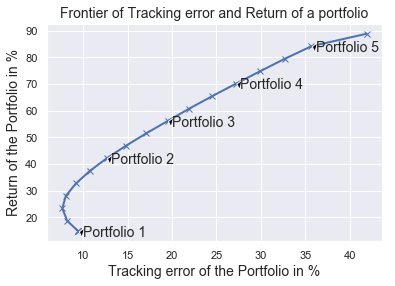

                         1     2     3     4     5
Expected Risk in %      15    20    26    33    41
Expected Return in %    14    42    56    70    84
Sharpe Ratio          0.86  1.97  2.05  2.03  1.98
Tracking Error in %      9    12    19    27    35
 please choose the portfolio you want to move a head with further analysis, enter the number
User: quit


In [139]:
# Set up Assistant service.
service = watson_developer_cloud.AssistantV2(iam_apikey = 'jAINB1_e24mDxYqqD8vsqMzr2XUYualRTbSKC1HMXndT', # replace with API key
    version = '2018-09-20')
assistant_id = '0d24f406-3df1-4d85-a93d-a39a64a95d1e' # replace with assistant ID

# assistant_id = '8b633fe1-b553-4f1e-b763-3a57854a5679' # replace with assistant ID
# Create session.
session_id = service.create_session(assistant_id = assistant_id).get_result()['session_id']

user_input = 'Hi'
index = pd.DataFrame()
instance = 0
graphinstance = 0
# Main input/output loop
while user_input != 'quit':

    # Send message to assistant.
    response = service.message(assistant_id,session_id,input = {'text': user_input}).get_result()

#     If an intent was detected, print it to the console.
#     if response['output']['intents']:
#         print('Detected intent: #' + response['output']['intents'][0]['intent'])
        
#     if response['output']['entities']:
#         print('Detected entity: @' + response['output']['entities'][0]['entity'])

    # Print the output from dialog, if any. Assumes a single text response.
    if response['output']['generic']:
        print('Bot: ' + response['output']['generic'][0]['text'])
        
    if response['output']['intents']:
        if response['output']['intents'][0]['intent'] == 'maxsharpe':
            shares,stocks = collectdatafromuser()
            weights, All = maxsharpe(shares)
            weightfinal = All.transpose().iloc[:-3,:][0]
            
            portfoliovaluetoday = 10000
            sharesholdingtoday = np.divide(weightfinal * portfoliovaluetoday,shares[stocks].iloc[-1,:])
            def portfoliovalue(row,shares = sharesholdingtoday ):
                return sum(row.multiply(shares))
            shares['Portfolio Value'] = shares[stocks].apply(portfoliovalue, axis=1)
            shares['Portfolio Value'] = shares['Portfolio Value'].astype(int)
            try:
                shares['Index'] = index
            except:
                shares['Index'] = getdataindex('gspc')
            indexholdingtoday =  np.divide(portfoliovaluetoday,shares['Index'].iloc[-1])
            def indexvalue(row,shares = indexholdingtoday):
                return row*shares
            shares['Market Index'] = shares['Index'].apply(indexvalue)
            shares['Market Index'] = shares['Market Index'].astype(int)            
            portvalueplot(shares)
            pieplot(weightfinal)
            
    
    if response['output']['intents']:
        if response['output']['intents'][0]['intent'] == 'equallyweighted':
            shares,stocks = collectdatafromuser()
            weights, All = equallyweighted(shares)
            weightfinal = All.transpose().iloc[:-3,:][0]
            
            portfoliovaluetoday = 10000
            sharesholdingtoday = np.divide(weightfinal * portfoliovaluetoday,shares[stocks].iloc[-1,:])
            def portfoliovalue(row,shares = sharesholdingtoday ):
                return sum(row.multiply(shares))
            shares['Portfolio Value'] = shares[stocks].apply(portfoliovalue, axis=1)
            shares['Portfolio Value'] = shares['Portfolio Value'].astype(int)
            try:
                shares['Index'] = index
            except:
                shares['Index'] = getdataindex('gspc')
            indexholdingtoday =  np.divide(portfoliovaluetoday,shares['Index'].iloc[-1])
            def indexvalue(row,shares = indexholdingtoday):
                return row*shares
            shares['Market Index'] = shares['Index'].apply(indexvalue)
            shares['Market Index'] = shares['Market Index'].astype(int)            
            portvalueplot(shares)
            pieplot(weightfinal)
             
                
    if response['output']['intents']:
        if response['output']['intents'][0]['intent'] == 'Black-Litterman':
            instance = 0
            instance = instance + 1
            BLreturns, MLreturns, shares,stocks,company,usernames = BlackLitterman()
            BLreturns = [x[0] for x in BLreturns]
            BLreturns = array(BLreturns)
#             print('The returns obtained by black litermann model after considering views are')
#             print(BLreturns)
#             print('The returns obtained by market equlibrium of the assets are')
#             print(MLreturns)

            barplotBL(BLreturns, MLreturns,usernames)
                                                
            weights, All = efficientfrontierabsolute(shares,blreturns = BLreturns)
            summary, weightschoosen = summarydfabsolute(All)

            efficientplot(All)
            print(summary)
            print("please choose the portfolio you want to move a head with further analysis, enter the number")
    
    if response['output']['intents']:
        if response['output']['intents'][0]['intent'] == 'companyname':       
            name = response['output']['entities'][0]['value']
            stock = findtheticker(name,y = dftickerstocksETF,i=0)
            print('the ticker of the stock '+name+' is' + stock)
        


    # this instance variable is proof that the strategy loop is called atleast once
    if response['output']['intents']:
        if response['output']['intents'][0]['intent'] == 'strategy':
            if response['output']['entities']:
                if response['output']['entities'][0]['value'] == 'passive':
                    instance = 0
                    instance = instance + 1
                    graphinstance = graphinstance + 1
                    print("For example some of the famous indexes include S&P500 (ticker: GSPC) and NASDAQ100 (ticker: IXIC)", end='\n')
                    print("enter the ticker of the index you would like to track")            
                    user_input_2 = input('>> ')
                    index = getdataindex(user_input_2)
                    shares,stocks = collectdatafromuser()
                    
                    weights, All = efficientfrontierrelative(shares,index)
                    summary, weightschoosen = summarydftracking(All)
#                     weightschoosen = summarydftracking(All)[1]

                    efficientplotabsolute(All)
                    print(summary)
                    print("\033[1;32;40m please choose the portfolio you want to move a head with further analysis, enter the number")


                if response['output']['entities'][0]['value'] == 'active':
                    instance = 0
                    instance = instance + 1
                    
                    shares,stocks = collectdatafromuser()    

                    shares = getdatastocks(stocks)
                    weights, All = efficientfrontierabsolute(shares)
                    summary, weightschoosen = summarydfabsolute(All)

                    efficientplot(All)
                    print(summary)
                    print("\033[1;32;40m please choose the portfolio you want to move a head with further analysis, enter the number")


    if response['output']['entities']:
        if response['output']['entities'][0]['entity'] == 'portfolio_number' and instance == 1:
            weightfinal = weightschoosen[response['output']['entities'][0]['value']]
            portfoliovaluetoday = 10000
            sharesholdingtoday = np.divide(weightfinal * portfoliovaluetoday,shares[stocks].iloc[-1,:])
            def portfoliovalue(row,shares = sharesholdingtoday ):
                return sum(row.multiply(shares))
            shares['Portfolio Value'] = shares[stocks].apply(portfoliovalue, axis=1)
            shares['Portfolio Value'] = shares['Portfolio Value'].astype(int)
            try:
                shares['Index'] = index
            except:
                shares['Index'] = getdataindex('gspc')
            indexholdingtoday =  np.divide(portfoliovaluetoday,shares['Index'].iloc[-1])
            def indexvalue(row,shares = indexholdingtoday):
                return row*shares
            shares['Market Index'] = shares['Index'].apply(indexvalue)
            shares['Market Index'] = shares['Market Index'].astype(int)            
            portvalueplot(shares)
            pieplot(weightfinal)
            x = simulation(weightfinal,shares[stocks],scenarios = 1500,capital = 10000,years = [1,3,5])
            histogram(x,3)
#             histogram(x,1)
#             histogram(x,5)

    # Prompt for next round of input.
    user_input = input('User: ')

# We're done, so we delete the session.d
service.delete_session(assistant_id = assistant_id,session_id = session_id)

In [ ]:
x = getdatastocks(['msft'])

#### Common tickers in Yahoo
MS, SBUX, JWN, aapl ,goog ,amzn ,pfe , bx , dis, dgaz, shop,crm, twlo,adbe, TWTR,QCOM


AMD,CELG,RMD,ARNC,

^GSPC	S&P 500, ^IXIC	Nasdaq, ^DJI	Dow 30,^NYA	NYSE COMPOSITE (DJ)

#### ETF
0	XBI	SPDR S&P Biotech ETF

1	PSCH	Invesco S&P SmallCap Health Care ETF

3	FBT	First Trust NYSE Arca Biotechnology Index Fund

4	ARKK	ARK Innovation ETF

5	QLD	


GLD – SPDR Gold Shares ETF.
EEM – iShares MSCI Emerging Markets ETF.
IEMG – iShares Core MSCI Emerging Markets ETF.
VTI – Vanguard Total Stock Market ETF.



In [ ]:
##### service.delete_session(assistant_id = assistant_id,session_id = session_id)

In [ ]:
# dftickerstocksETF.head()

In [ ]:
# dftickerstocksETF.tail()

In [140]:
# dftickerstocksETF.tail()

In [ ]:
# topstockslistyahoo.head(10)

In [ ]:
# topETFlistyahoo.head(10)

In [ ]:
# describe('ms').tail()